In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.sparse import csr_matrix #csr_array
from jftools.fedvr import fedvr_grid
from jftools.short_iterative_lanczos import sesolve_lanczos
from laserfields import make_laserfield

In [2]:
plt.style.use('https://johannesfeist.eu/misc/jf_cb.mplstyle')

# Model molecule
In this notebook, we treat nuclear motion in a molecule described by two potential energy surfaces, i.e., we have only electronic states, but include nuclear motion. Note that we assume that the surfaces are separated far enough that the Born-Oppenheimer approximation is "perfect", i.e., there are no non-adiabatic coupling terms. We model the nuclear potentials as [Morse potentials](https://en.wikipedia.org/wiki/Morse_potential).

In [3]:
@dataclass
class MorsePotential:
    E0: float
    De: float
    a: float
    re: float
        
    # to call as V(r)
    def __call__(self,r):
        return self.E0 + self.De*(1-np.exp(-self.a*(r-self.re)))**2
    # maximum bound eigenvalue
    def nmax(self,M):
        return int(np.sqrt(2*self.De*M)/self.a - 1)
    # returns the nth analytical eigenvalue (only valid up to nmax )
    def eigval(self,M,n):
        ω0 = self.a*np.sqrt(2*self.De/M)
        return self.E0 + ω0*(n+0.5) - (ω0*(n+0.5))**2/(4*self.De)

In [4]:
# # https://doi.org/10.1119/1.4722793
# k0 = 1235*nu.N/nu.m
# De = 7.37*nu.eV
# a = np.sqrt(k0/(2*De))
# Vg = MorsePotential(0.,De/nu.eV,a*nu.Å,1.2)
# # N2 molecule, https://doi.org/10.1063/1.555892
# VX = MorsePotential(0.,)

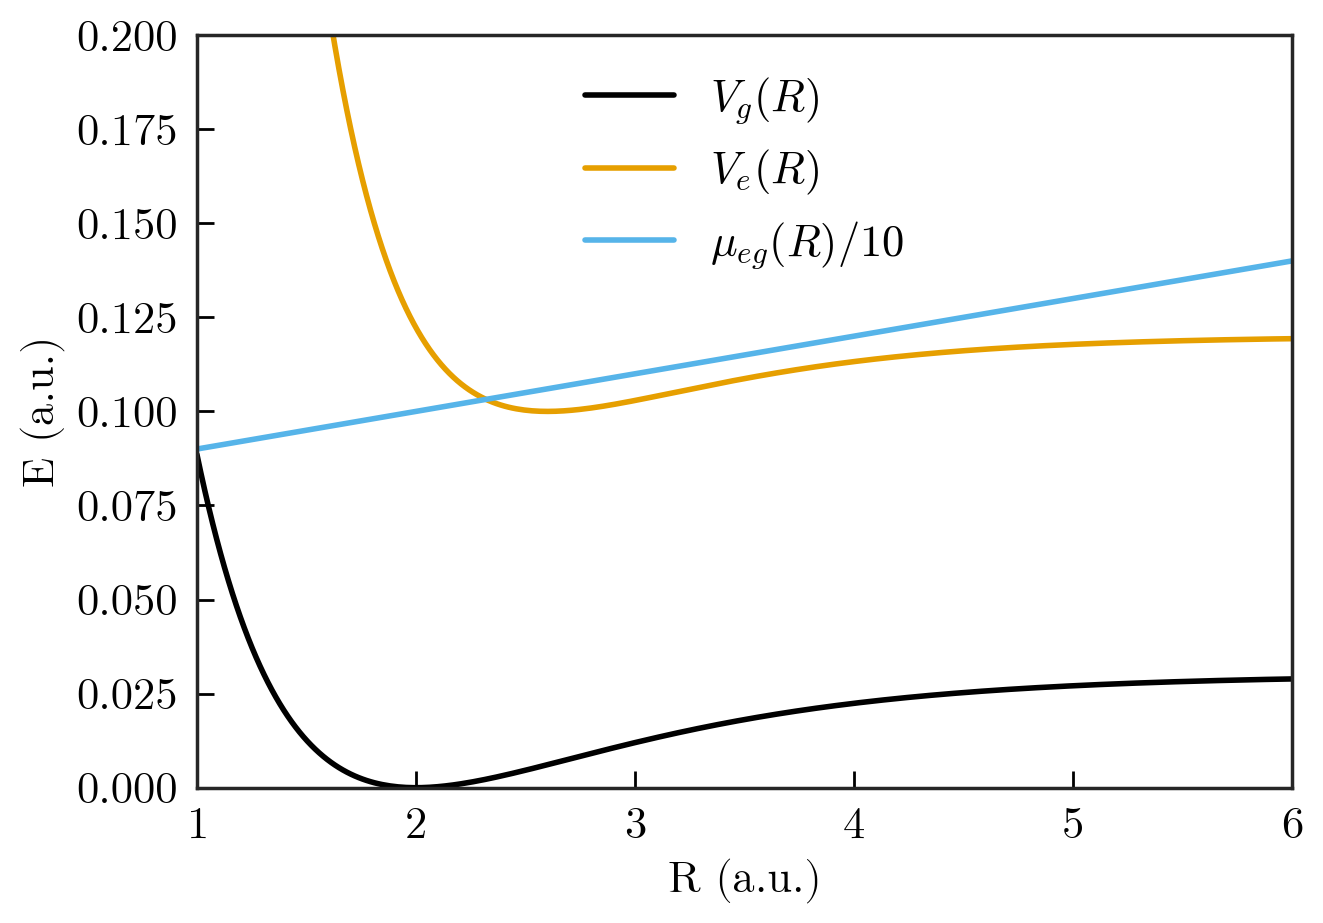

In [5]:
M = 2 * 1836.15267
Vg = MorsePotential(0.0,0.03,1.0,2.0)
Ve = MorsePotential(0.1,0.02,1.2,2.6)
μeg = lambda R: 1 + 0.1*(R-2)
Rplt = np.linspace(1,10,501)
plt.plot(Rplt,Vg(Rplt),label=r"$V_g(R)$")
plt.plot(Rplt,Ve(Rplt),label=r"$V_e(R)$")
plt.plot(Rplt,μeg(Rplt)/10,label=r"$\mu_{eg}(R)/10$")
plt.xlim(1,6)
plt.ylim(0,0.2)
plt.xlabel("R (a.u.)")
plt.ylabel("E (a.u.)")
plt.legend();

In [6]:
grid = fedvr_grid(15,np.arange(1,10.1,0.25))
R = grid.x
# FEDVR weights
wt = grid.wt

# Kinetic energy operator
KE = -grid.dx2/(2*M)

In [7]:
Hg = KE.toarray() + np.diag(Vg(R))
He = KE.toarray() + np.diag(Ve(R))

In [8]:
def eigh_with_signfix(H):
    vals, vecs = np.linalg.eigh(H)
    # sign of eigenvectors is arbitrary, fix so largest value is positive
    for ii in range(len(vals)):
        v = vecs[:,ii]
        v *= np.sign(v[np.argmax(abs(v))])
    return vals, vecs

valsG, vecsG = eigh_with_signfix(Hg)
valsE, vecsE = eigh_with_signfix(He)

# Check energies in Morse potential
We compare the analytical eigenvalues of the Morse potential (valid for the bound states) with the numerically obtained ones.

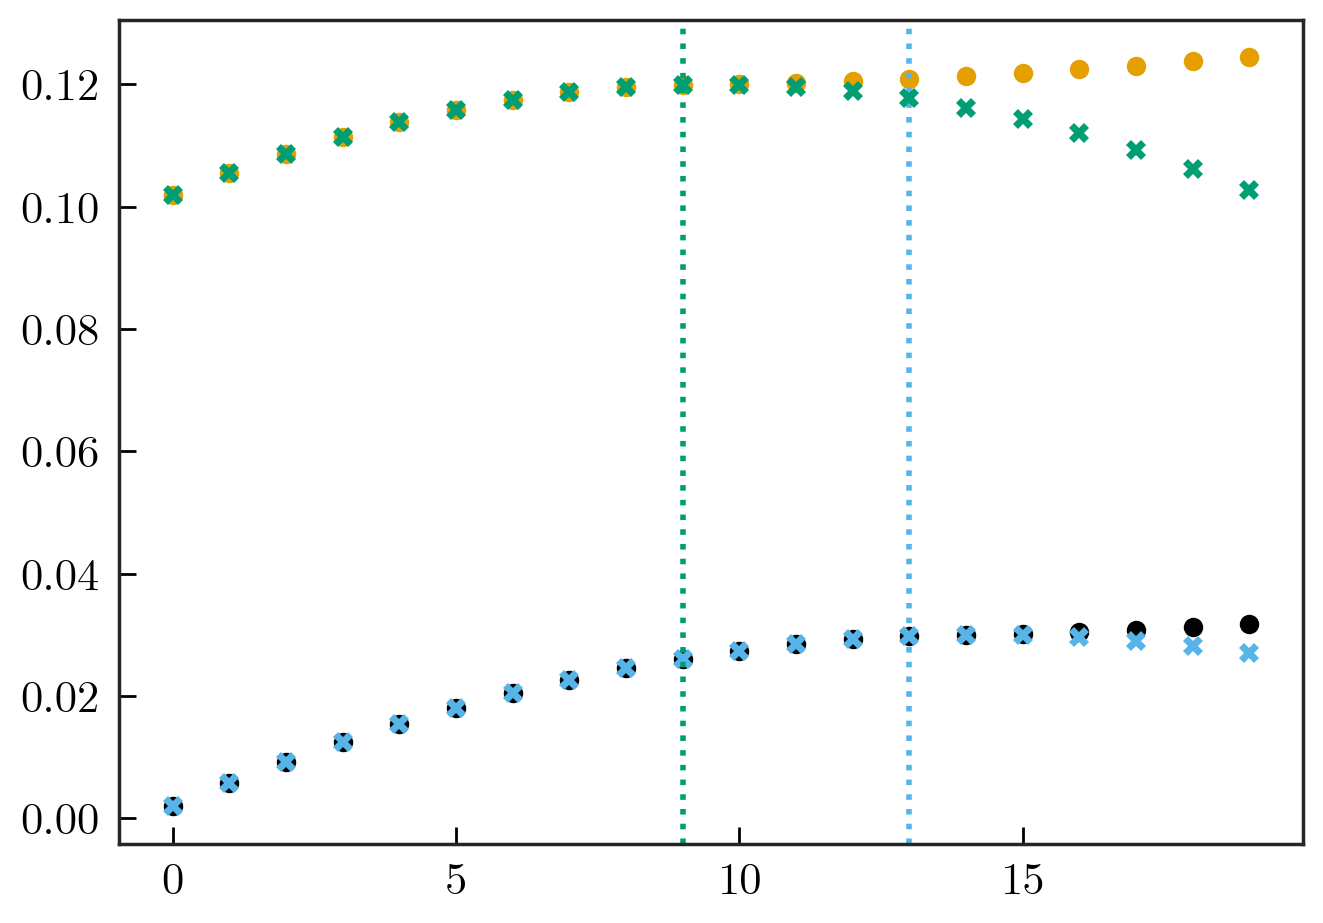

In [9]:
ns = np.arange(20)
plt.plot(valsG[ns],'o')
plt.plot(valsE[ns],'o')
for V in (Vg,Ve):
    l, = plt.plot(V.eigval(M,ns),'X')
    plt.axvline(V.nmax(M),color=l.get_color(),ls=":")

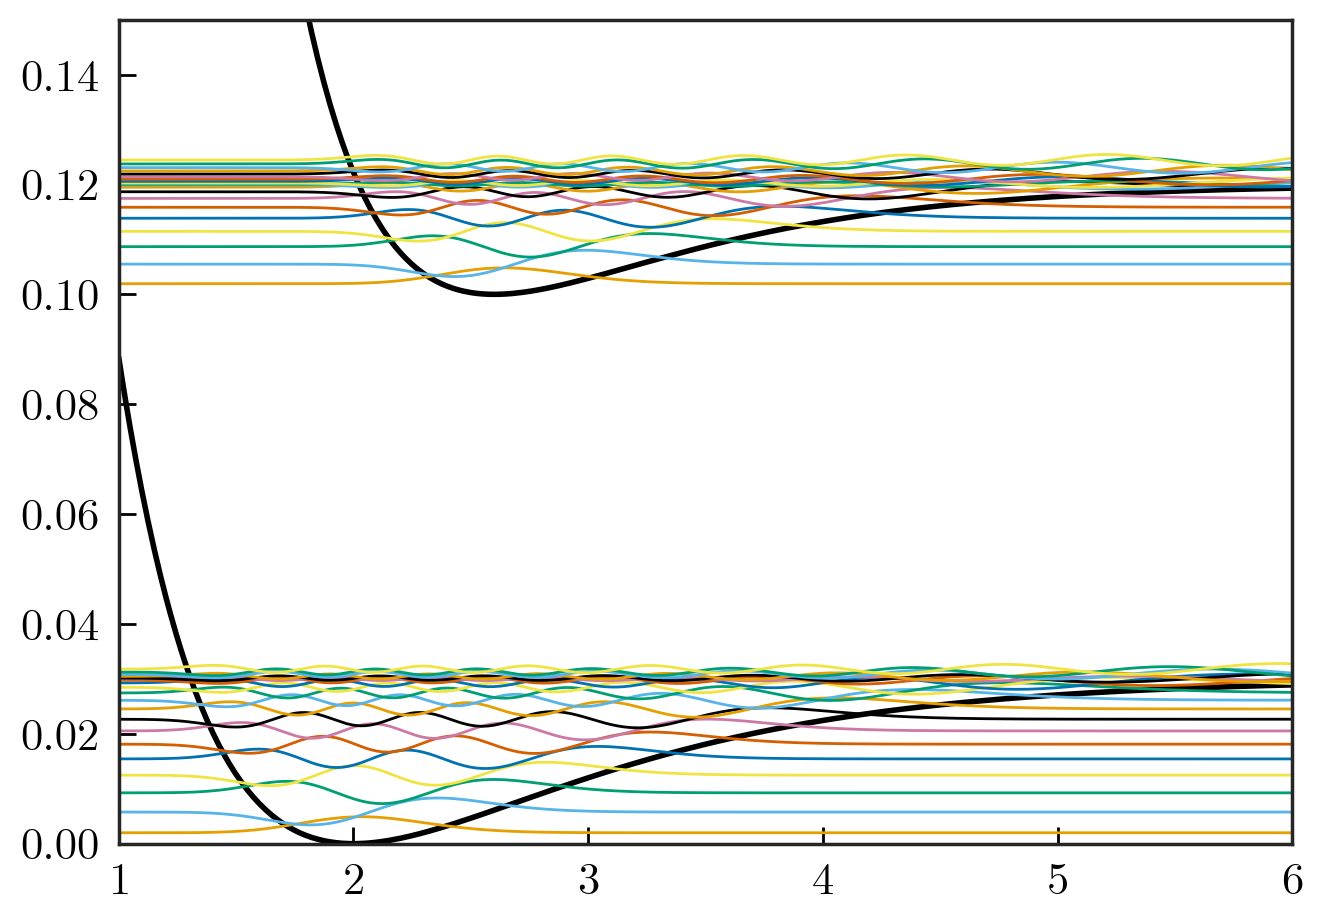

In [10]:
plt.plot(R,Vg(R))
plt.plot(R,Ve(R),'C0')
for ii in range(20):
    plt.plot(R,valsG[ii] + 0.002*vecsG[:,ii]/np.sqrt(wt), color=f"C{ii+1}",lw=1)
    plt.plot(R,valsE[ii] + 0.002*vecsE[:,ii]/np.sqrt(wt), color=f"C{ii+1}",lw=1)
plt.xlim(R[0],6)
plt.ylim(0,0.15);

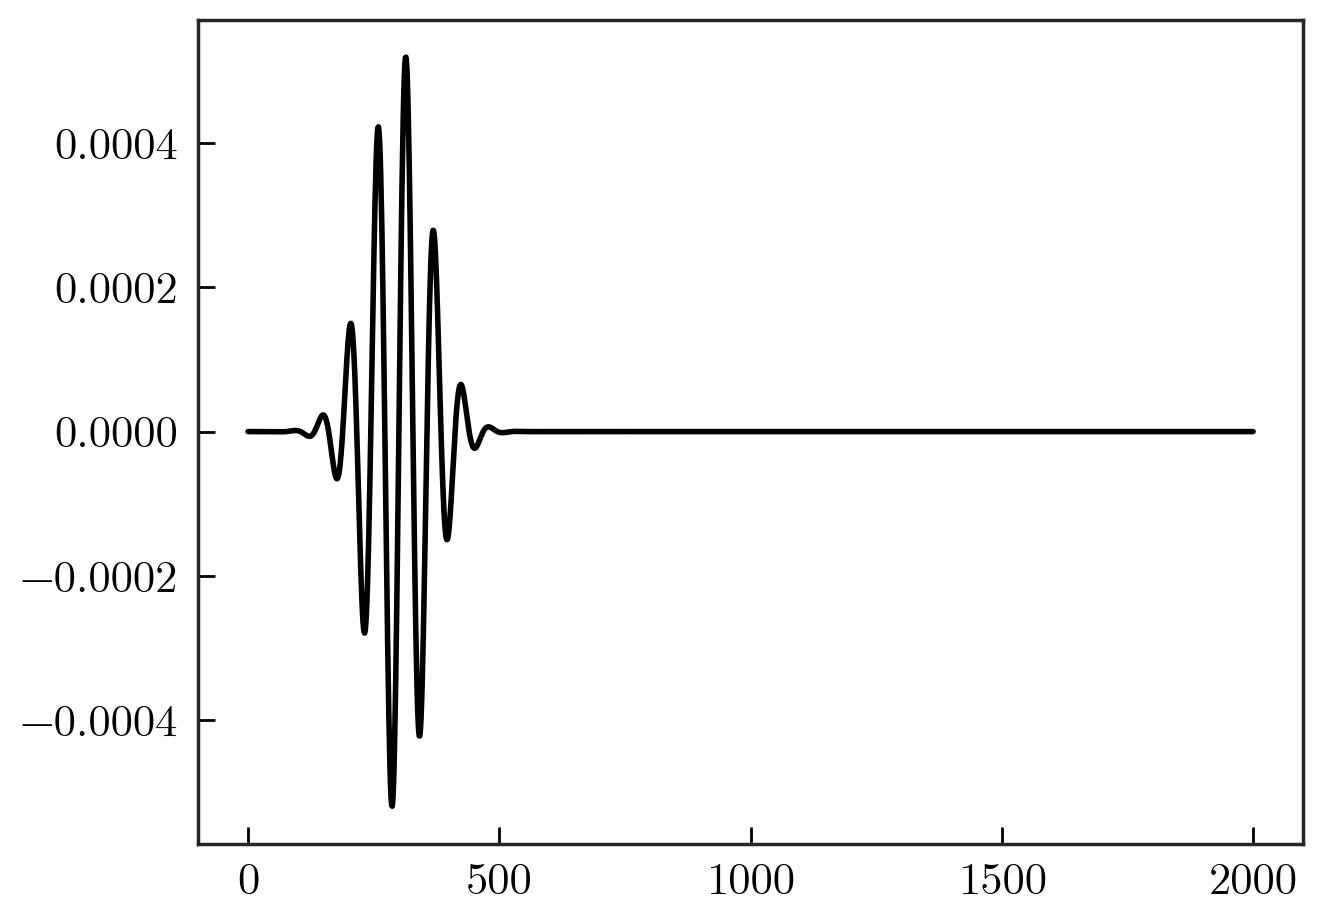

In [11]:
lf = make_laserfield(form="gaussianI",is_vecpot=True,duration=100.,intensity_Wcm2=1e10,ω0=0.11,peak_time=300.,phase_pi=0.5)
ts = np.arange(0,2000,lf.TX/50)
plt.plot(ts,lf(ts));

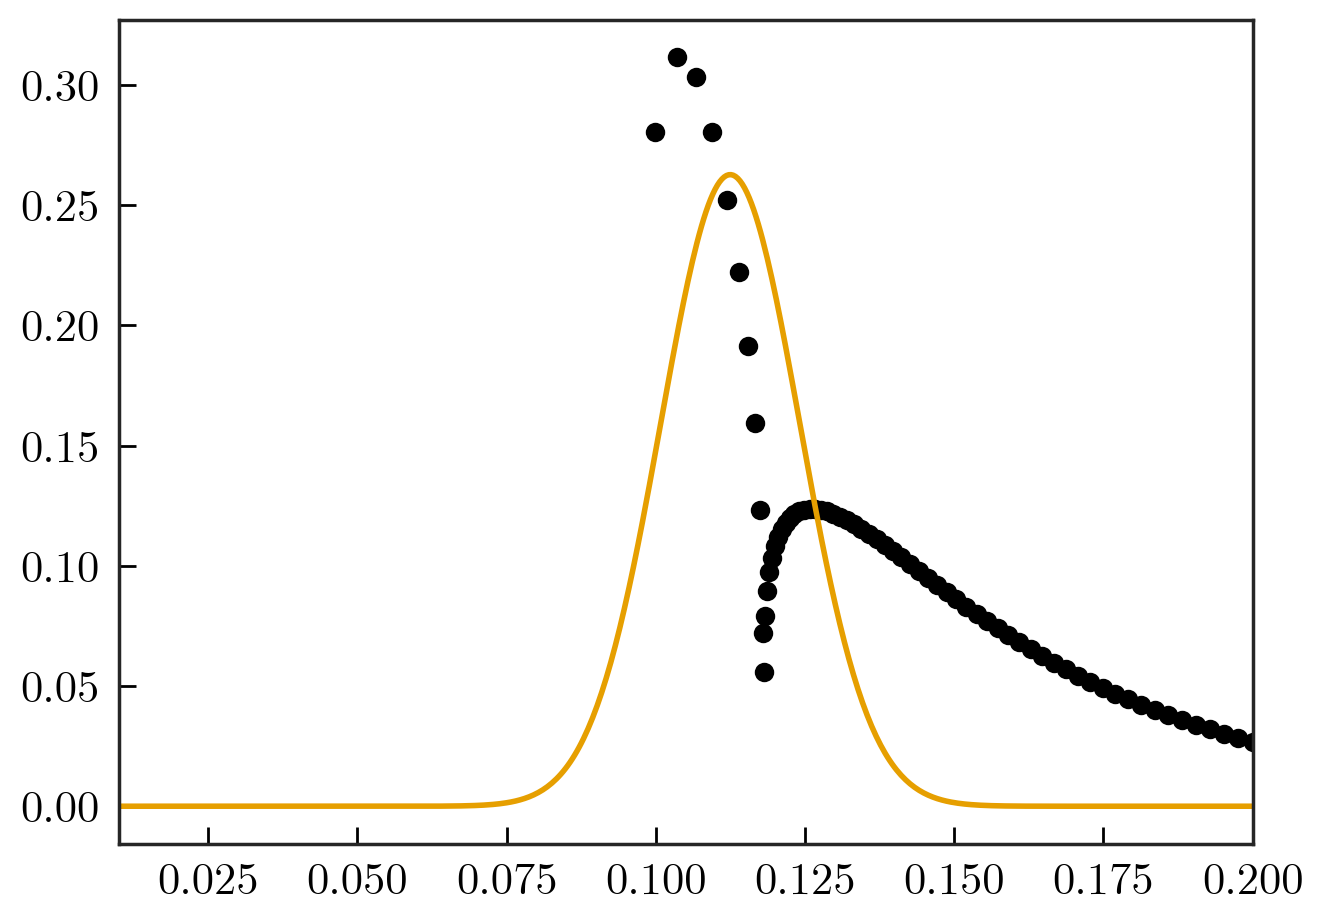

In [12]:
μEG = vecsE.T @ np.diag(μeg(R)) @ vecsG
ωs = np.linspace(0.01,0.2,501)
plt.plot(valsE-valsG[0], abs(μEG[:,0]), 'o')
plt.plot(ωs,abs(lf.E_fourier(ωs))**2 * 1e3)
plt.xlim(0.01,0.2);

The total Hamiltonian consist of two blocks for the electronic ground and excited states $H_0 = \begin{pmatrix}H_g & 0\\0 & H_e\end{pmatrix}$, while the dipole operator is off-diagonal, $\hat{\mu} = \begin{pmatrix}0 & \hat{\mu}_{eg}\\ \hat{\mu}_{eg} & 0\end{pmatrix}$. Note that here, $H_g$, $H_e$, and $\hat{\mu}_{eg}$ are themselves matrices (with the size of the radial grid). For the numerical time propagation, convert the "full" matrices we used up to now to "sparse matrices" where only non-zero matrix elements are stored (with `csr_matrix` from `scipy.sparse`).

In [13]:
H0 = csr_matrix(np.block([[Hg,0*Hg],[0*Hg,He]]))
μmat = np.diag(μeg(R))
μ = csr_matrix(np.block([[0*Hg, μmat],[μmat, 0*Hg]]))
def applyH(t,psi,Hpsi):
    Hpsi[:] = H0.dot(psi) + lf(t)*μ.dot(psi)
    return Hpsi

In [14]:
vals, vecs = np.linalg.eigh(H0.toarray())
psi0 = np.asarray(vecs[:,0], dtype=complex)

In [15]:
psis = np.array(sesolve_lanczos(applyH,psi0,ts,12,1e-12,maxHT=lf.TX/200))

In [16]:
c0s = psis @ psi0
psis_exc = psis - c0s[:,None] * psi0

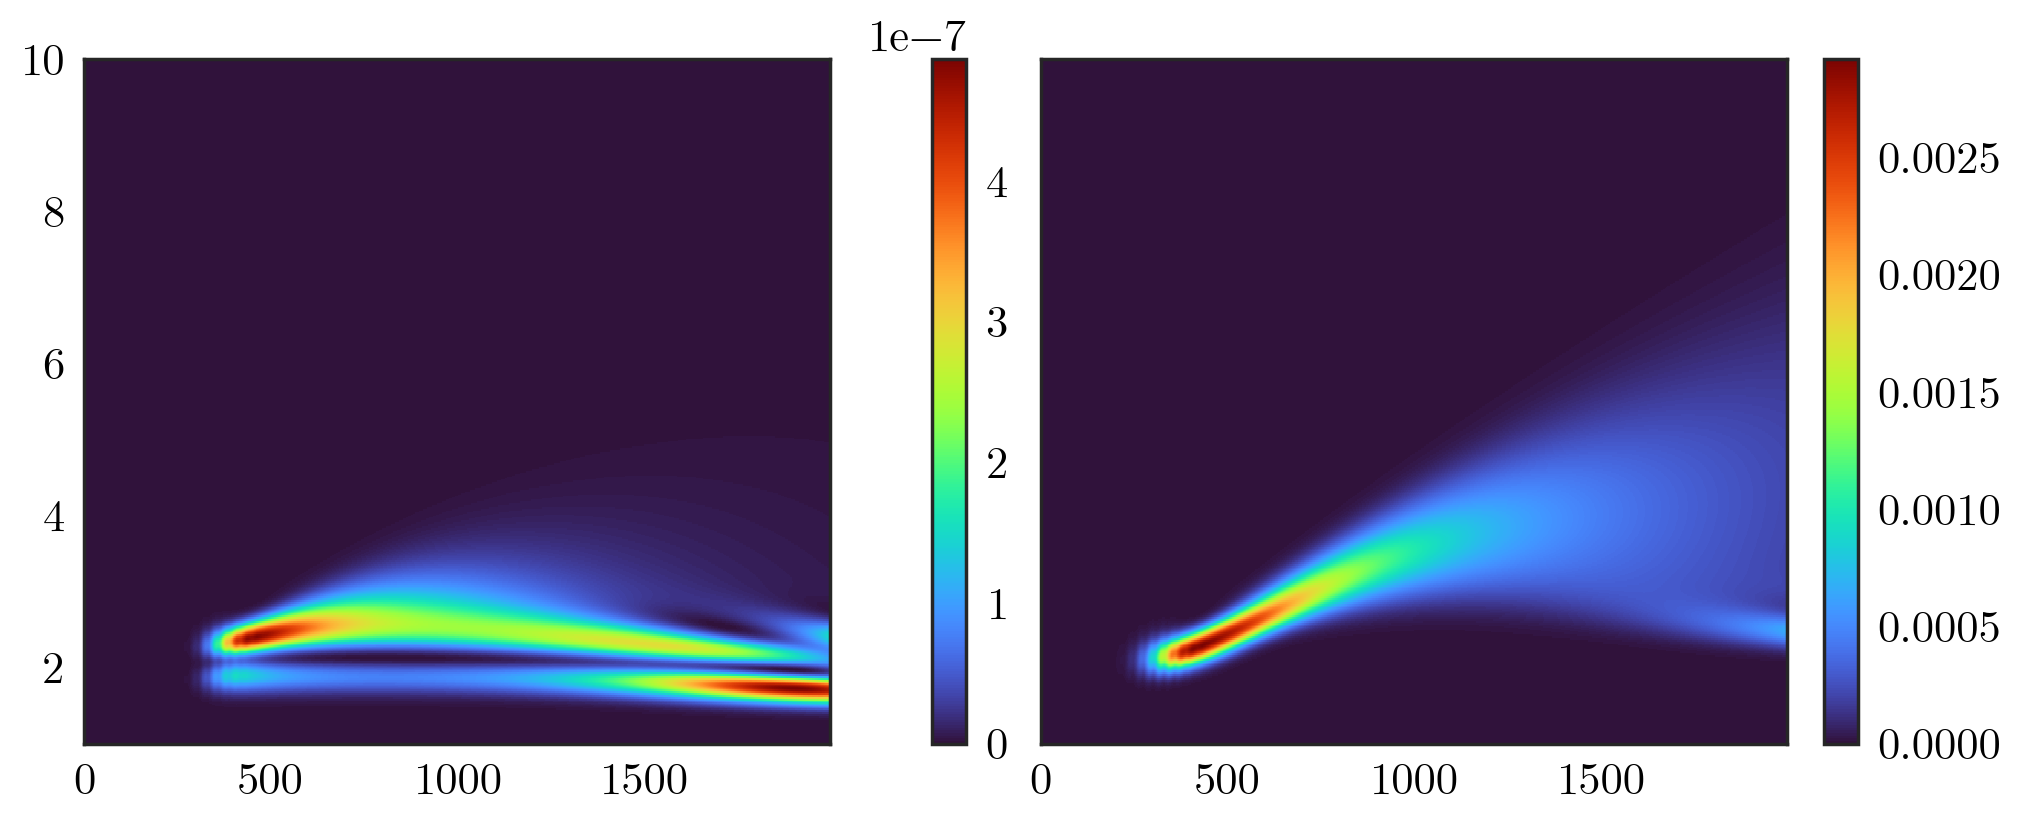

In [17]:
fig,axs = plt.subplots(1,2,figsize=(10,4),sharey=True,sharex=True)
im = axs[0].pcolormesh(ts,R,abs(psis_exc[:,:len(R)]**2/wt).T)
plt.colorbar(im)
im = axs[1].pcolormesh(ts,R,abs(psis_exc[:,len(R):]**2/wt).T)
plt.colorbar(im);

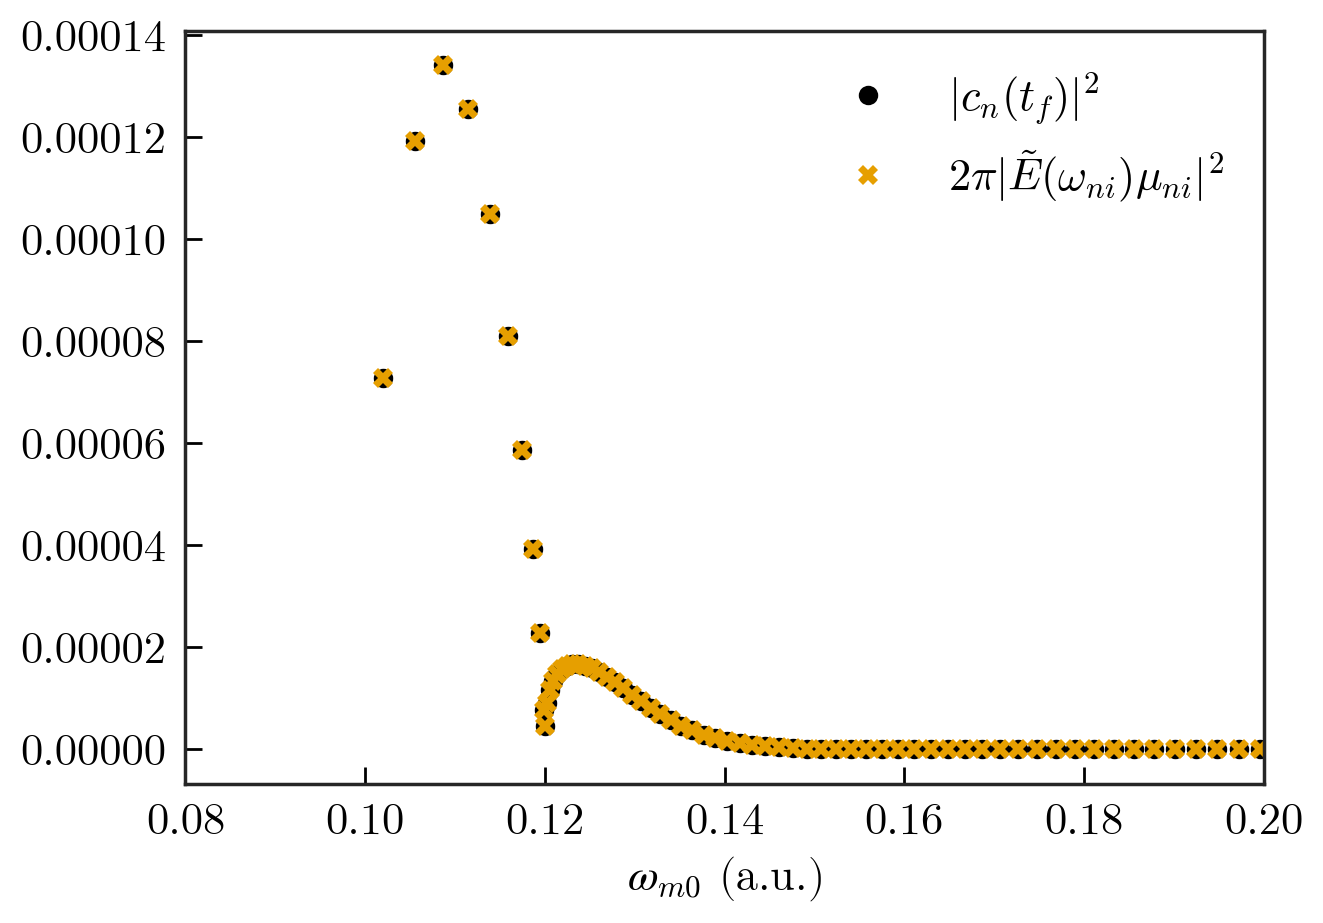

In [18]:
psif_E = vecsE.T @ psis[-1,len(R):]
plt.plot(valsE,abs(psif_E)**2,'o',label=r"$|c_n(t_f)|^2$")
plt.plot(valsE,abs(lf.E_fourier(valsE-valsG[0])*μEG[:,0])**2 * 2*np.pi, 'X', label=r"$2\pi|\tilde{E}(\omega_{ni}) \mu_{ni}|^2$")
plt.xlim(0.08,0.2)
plt.xlabel(r"$ω_{m0}$ (a.u.)")
plt.legend();